***

*Course:* [Math 535](https://people.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS) - Fall 2022

*Name:* Samyu Iyer 

***

# HWK 5

**Instructions:**

1. Open the notebook in [Google Colab](https://colab.research.google.com/).

2. Download the required dataset from Canvas.

3. In the Jupyter notebook, write your name above and do the exercises below.

4. Run every cell.

5. In the File menu, print and "Save as PDF". Before this step, make sure to "Restart & Run All" in the "Runtime" menu. The cell outputs should be numbered in order. 

6. Due date and instructions to submit your PDF will be given on Canvas.

In [98]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
from numpy.random import default_rng
import matplotlib.pyplot as plt

rng = default_rng(535)

def mmids_backsubs(U,b):
    m = b.shape[0]
    x = np.zeros(m)
    for i in reversed(range(m)):
        x[i] = (b[i] - np.dot(U[i,i+1:m],x[i+1:m]))/U[i,i]
    return x

def mmids_forwardsubs(L,b):
    m = b.shape[0]
    x = np.zeros(m)
    for i in range(m):
        x[i] = (b[i] - np.dot(L[i,0:i],x[0:i]))/L[i,i]
    return x

def mmids_cholesky(B):
    n = B.shape[0] # number of rows
    L = np.zeros((n, n)) # initiallization of L
    for j in range(n):
        L[j,0:j] = mmids_forwardsubs(L[0:j,0:j],B[j,0:j])
        L[j,j] = np.sqrt(B[j,j] - LA.norm(L[j,0:j])**2)
    return L 

def ols_by_chol(A, y):
    L = mmids_cholesky(A.T @ A)
    z = mmids_forwardsubs(L, A.T @ y)
    return mmids_backsubs(L.T, z)

In [99]:
# IF RUNNING ON GOOGLE COLAB
# When prompted, upload: 
#     * chwk2-data.csv 
# from your local file system
# Data source: https://www.math.wisc.edu/~roch/mmids/
# Alternative instructions: https://colab.research.google.com/notebooks/io.ipynb

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving hwk5-f22-data.csv to hwk5-f22-data (2).csv
User uploaded file "hwk5-f22-data.csv" with length 55910 bytes


**Background** The goal of this assignment is to develop an important practical variant of the least squares problem. Recall that in the basic approach to linear regression, also known as ordinary least squares, we seek an affine function to fit data points $\{(\mathbf{x}_i, y_i)\}_{i=1}^n$, where $\mathbf{x}_i \in \mathbb{R}^d$ are the predictor variables of the $i$-th sample and $y_i \in \mathbb{R}$ is the corresponding response. More precisely, we want coefficients $\beta_j$'s that minimize the objective function

$$
\sum_{i=1}^n \left(y_i - \left\{\beta_0 + \sum_{j=1}^d \beta_j x_{i,j}\right\}\right)^2.
$$

Under the matrix form of the problem:

(a) we construct

$$
\mathbf{y} = 
\begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix},
\quad\quad
A =
\begin{pmatrix}
1 & \mathbf{x}_1^T \\
1 & \mathbf{x}_2^T \\
\vdots & \vdots \\
1 & \mathbf{x}_n^T
\end{pmatrix}
\quad\text{and}\quad
\boldsymbol{\beta} = 
\begin{pmatrix}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_d
\end{pmatrix}, \qquad (*)
$$

which leads to the reformulation

$$
\min_{\boldsymbol{\beta}} 
\|\mathbf{y} 
- A \boldsymbol{\beta}\|^2;
$$

(b) we then consider the normal equations

$$
A^T A \boldsymbol{\beta}^* = A^T \mathbf{y}
$$

which can be solved using a Cholesky decomposition $A^T A = L L^T$, where $L$ is lower-triangular with positive entries on the diagonal. The function `ols_by_chol` above implements this approach.

In ordinary least squares, all data points are weighted equally in the objective function

$$
\sum_{i=1}^n \left(y_i - \left\{\beta_0 + \sum_{j=1}^d \beta_j x_{i,j}\right\}\right)^2.
$$

In weighted least squares, which we develop here, one is also given positive weights $w_i \in \mathbb{R}_+$ for each data point $i = 1,\ldots, n$, and we seek a solution to

$$
\sum_{i=1}^n w_i \left(y_i - \left\{\beta_0 + \sum_{j=1}^d \beta_j x_{i,j}\right\}\right)^2.
$$

Why might we want to do this? One key consideration is that different data points may come with different degrees of imprecision. And we may be interested in weighing more heavily those data points that are more reliable.

For instance, have a look at the simulated dataset below. Here the standard deviation of the noise, `std`, is a quadratic function of the predictor variable, `x`. This is known as [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity). For predictor values in the neighborhood of 4, the response is very close to linear, with little noise obfuscating the signal. Away from that region, however, the data appears to be significantly more noisy and one can barely detect a functional relationship.    

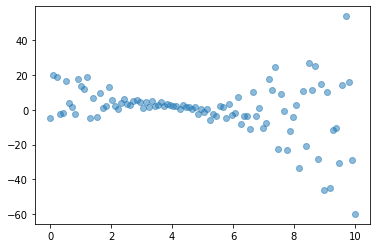

In [101]:
n, b0, b1 = 100, 10, -2
x = np.linspace(0,10,num=n)
std = 1 + (x - 4)**2
y = b0 + b1 * x + std * rng.normal(0,1,n)
plt.scatter(x,y,alpha=0.5)
plt.show()

**PART A: Weighted least squares solution** We will come back below to how we might set the weights $w_i$ in a principled manner. For now, we solve the weighted least squares problem by recasting it in the ordinary version. To do this, we perform a change of variables. Observe that the weighted least squares objective can be re-written as

$$
\sum_{i=1}^n w_i \left(y_i - \left\{\beta_0 + \sum_{j=1}^d \beta_j x_{i,j}\right\}\right)^2
= \sum_{i=1}^n \left(\sqrt{w_i} y_i - \left\{\beta_0 \sqrt{w_i} + \sum_{j=1}^d  \beta_j \sqrt{w_i} x_{i,j}\right\}\right)^2.
$$

The right-hand side can be interpreted as an ordinary least squares problem with the transformed predictors and responses

$$
\tilde{\mathbf{y}} = 
\begin{pmatrix}
\sqrt{w_1} y_1 \\
\sqrt{w_2} y_2 \\
\vdots \\
\sqrt{w_n} y_n
\end{pmatrix},
\quad\quad
\widetilde{A} =
\begin{pmatrix}
\sqrt{w_1} & \sqrt{w_1} \mathbf{x}_1^T \\
\sqrt{w_2} & \sqrt{w_2} \mathbf{x}_2^T \\
\vdots & \vdots \\
\sqrt{w_n} & \sqrt{w_n} \mathbf{x}_n^T.
\end{pmatrix}
$$

Define $W^{1/2}$ as the diagonal matrix with entries $\sqrt{w_i}$, $i=1,\ldots,n$, on its diagonal. Then we get that $\tilde{\mathbf{y}} = W^{1/2} \mathbf{y}$ and $\widetilde{A} = W^{1/2} A$. Hence the normal equations read

$$
\widetilde{A}^T \widetilde{A} \boldsymbol{\beta}^* 
= \widetilde{A}^T \tilde{\mathbf{y}},
$$

which can be re-written as

$$
A^T W^{1/2} W^{1/2} A \boldsymbol{\beta}^* 
= A^T W^{1/2} W^{1/2} \mathbf{y},
$$

where we used that the transpose of a diagonal matrix is itself. Define $W$ as the diagonal matrix with entries $w_i$, $i=1,\ldots,n$, on its diagonal, and note that $W = W^{1/2} W^{1/2}$. Therefore, we finally get

$$
A^T W A \boldsymbol{\beta}^* 
= A^T W \mathbf{y},
$$

which we refer to as the weighted normal equations. How do we solve them?

We use four steps. Let 

$$
C = A^T W A. \qquad (\text{Step I})
$$

When $A$ has linearly independent columns and the weights $w_i$ are strictly positive, it can be shown that the matrix $C$ is positive definite. Hence it has a Cholesky decomposition 

$$
C = M M^T, \qquad (\text{Step II})
$$

where $M$ is lower-triangular. And we can solve the weighted normal equations $M M^T \boldsymbol{\beta}^* = A^T W \mathbf{y}$ by forward substitution

$$
M \mathbf{z} = A^T W \mathbf{y}, \qquad (\text{Step III})
$$

followed by back-substitution

$$
M^T \boldsymbol{\beta}^* = \mathbf{z}, \qquad (\text{Step IV})
$$

similarly to what we did in the ordinary case.

**Question 1:** First use *ordinary least squares (OLS)* to fit the simulated dataset above. Construct the matrix $A$ as in $(*)$. (Do not forget the column of $1$'s for the constant term.) Then use `ols_by_chol` to obtain the coefficients.

In [102]:
#A = #EDIT: Construct matrix A as in (*)
ones_col = np.ones((len(x), 1)).reshape(100,1)
A = np.hstack([ones_col, x.reshape(100,1)])

In [103]:
coeff_ols = ols_by_chol(A, y)
#EDIT: Use ols_by_chol to compute coefficients
print(coeff_ols)

[ 8.37620144 -1.58990636]


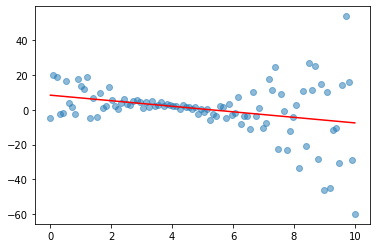

In [104]:
plt.scatter(x,y,alpha=0.5)
plt.plot(x,coeff_ols[0]+coeff_ols[1]*x,'r')
plt.show()

**Question 2:** Implement the four steps above to compute the solution to the *weighted least squares (WLS)* problem. 

In [105]:
def wls_by_chol(A, y, w):
    W = np.diag(w)
    C = A.T @ W @ A #(Step I)
    M = A.T @ W @ y #(Step II)
    L = mmids_cholesky(A.T @ W @ A)
    z = mmids_forwardsubs(L, A.T @ W @ y) #(Step III)
    return mmids_backsubs(L.T, z) #EDIT: Use mmids_backsubs to return the coefficients (Step IV)

**Question 3:** It can be shown that a good choice for the weights is "one over the variance of the noise". Here that would be one over the square of the `std` value corresponding to each sample. Set the weights, compute the WLS solution using `wls_by_chol`, and plot both the OLS and WLS lines.

In [106]:
w = [1/(std[i]**2) for i in range(len(std))] #EDIT: Set the weights from the vector `std` defined in the simulation
coeff_wls = wls_by_chol(A, y, w) #EDIT: Use wls_by_chol to compute the WLS coefficients
print(coeff_wls)

[ 9.03404227 -1.73862357]


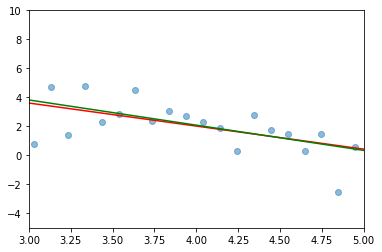

In [107]:
plt.scatter(x,y,alpha=0.5)
#EDIT: Plot the OLS line (in red)
#EDIT: Plot the WLS line (in green)
plt.plot(x,coeff_ols[0]+coeff_ols[1]*x,'r')
plt.plot(x,coeff_wls[0]+coeff_wls[1]*x,'g')

plt.xlim((3,5))
plt.ylim((-5,10))
plt.show()

**Part B: Estimating the weights** We will illustrate how one might estimate the weights using additional information on a dataset from [Cosma Shalizi](http://www.stat.cmu.edu/~cshalizi/). Quoting from him: 

"The data file has information on 729 communities. The variable we want to predict is economic mobility; the rest are predictor variables or
covariates.

1. Mobility: The probability that a child born in 1980–1982 into the lowest
quintile (20%) of household income will be in the top quintile at age 30. Individuals are assigned to the community they grew up in, not the one
they were in as adults.

2. Commute: Fraction of workers with a commute of less than 15 minutes.

3. Longitude: Geographic coordinate for the center of the community

4. Latitude: Ditto

5. Name: the name of principal city or town.

6. State: the state of the principal city or town of the community

An important hypothesis for the researchers who gathered this data is that
short commuting times lead to higher rates of social mobility. In this assignment,
we will not be concerned with their explanation of how this might work, but
just with whether there really is such a connection."

Specifically, our goal in this part is to use both OLS and WLS to fit a line relating `Commute` (the predictor) and `Mobility` (the response). The weights in the WLS approach will be derived from the `Population` values.

**Question 4:** First, load the dataset `hwk5-f22-data.csv` into a dataframe, print the first 5 rows and compute the number of rows.

In [108]:
df = pd.read_csv('hwk5-f22-data (2).csv') #EDIT: Load `hwk5-f22-data.csv` into dataframe
#EDIT: Print the first five rows of df
df.head()

,Name,Mobility,State,Population,Commute,Longitude,Latitude
0,Johnson City,0.062199,TN,576081,0.325,-82.436386,36.470371
1,Morristown,0.053652,TN,227816,0.276,-83.407249,36.096539
2,Middlesborough,0.072635,TN,66708,0.359,-83.535332,36.551540
3,Knoxville,0.056281,TN,727600,0.269,-84.242790,35.952259
4,Winston-Salem,0.044801,NC,493180,0.292,-80.505333,36.081276


In [109]:
n_cities = len(df) #EDIT: Compute the number of rows
print(n_cities)

729


**Question 5:** Extract the columns `Mobility`, `Commute` and `Population` into vectors, i.e., 1d arrays. Plot histograms of `mobility` and `commute` and of the logarithm of `population`. Taking a logarithm of the population is warranted here because it is spread over many orders of magnitude.

In [110]:
mobility = df['Mobility'].to_numpy() #EDIT: Convert column `Mobility` into 1d array
commute = df['Commute'].to_numpy() #EDIT: Convert column `Commute` into 1d array
population = df['Population'].to_numpy() #EDIT: Convert column `Population` into 1d array

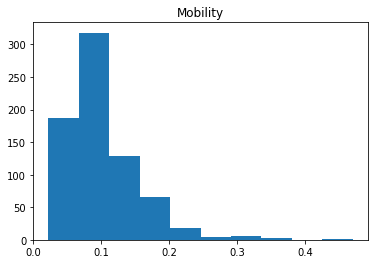

In [111]:
#EDIT: Plot histogram of `mobility`
plt.hist(mobility)
plt.title("Mobility")
plt.show()

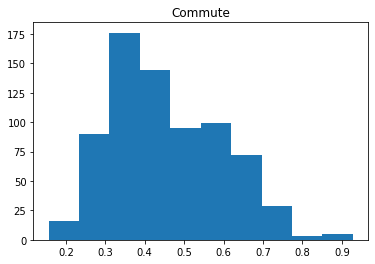

In [112]:
#EDIT: Plot histogram of `commute`
plt.hist(commute)
plt.title("Commute")
plt.show()

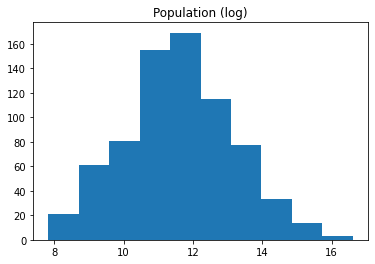

In [113]:
#EDIT: Plot histogram of the log of `population`
plt.hist(np.log(population))
plt.title("Population (log)")
plt.show()

**Question 6:** Use OLS to fit a line relating `commute` (as predictor) and `mobility` (as response). First construct the matrix $A$ as in $(*)$ (here `data_matrix`; do not forget the column of $1$'s for the constant term), then use `ols_by_chol` to compute the coefficients. Finally plot the OLS line.

In [114]:
#EDIT: Compute A matrix as in (*)
ones_col = np.ones((len(commute), 1))
data_matrix = np.hstack([ones_col, commute.reshape(len(commute),1)])

In [116]:
coeff_ols = ols_by_chol(data_matrix, mobility)
#EDIT: Use ols_by_chol to solve for OLS coefficients
print(coeff_ols)

[-1.97258903e-04  2.21869529e-01]


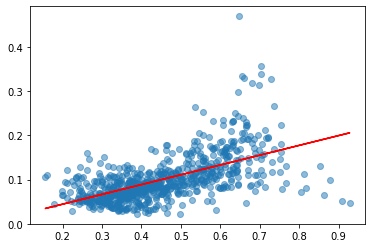

In [117]:
plt.scatter(commute,mobility,alpha=0.5)

x = np.linspace(np.min(commute),np.max(commute),num=100)
#EDIT: Plot the OLS line (in red)
plt.plot(commute,coeff_ols[0]+coeff_ols[1]*commute,'r')


plt.show()

**Question 7:** Display a scatterplot of the logarithm of the `population` (on $x$ axis) and the `mobility` (on $y$ axis). Notice that the spread along the $y$ axis increases as the $x$-value gets smaller. This is evidence that smaller populations lead to more uncertain estimates of economic mobility.

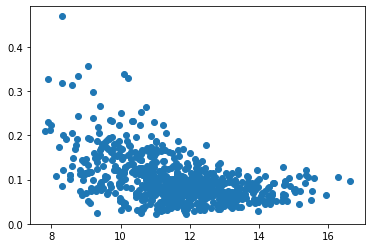

In [118]:
#EDIT: Display scatter of log of population and mobility
plt.scatter(np.log(population), mobility)
plt.show()

**Question 8:** We will use again the "one over the variance of the noise" principle as the weight in WLS. Without going into the details: (1) we assume that the estimate of economic mobility follows a normalized binomial distribution with a number of trials proportional to the population size; (2) it can be shown that, under that model, the variance of the mobility can be approximated by $\frac{(1-m_i)m_i}{n_i}$, where $m_i$ and $n_i$ are the economic mobility and population size of community $i$. Compute the weights, solve the WLS problem and plot the OLS and WLS lines.

In [122]:
var = [(1-mobility[i])*mobility[i]/population[i] for i in range(len(mobility))] #EDIT: Compute the approximation to the variance (1-m_i)*m_i/n_i
weights = [1/(var[i]) for i in range(len(var))]
#EDIT: Set the weigths using the "one over the variance" principle

In [128]:
coeff_wls = wls_by_chol(data_matrix, mobility, weights) #EDIT: Use wls_by_chol to compute WLS coefficients
print(coeff_wls)

[0.06405243 0.03106309]


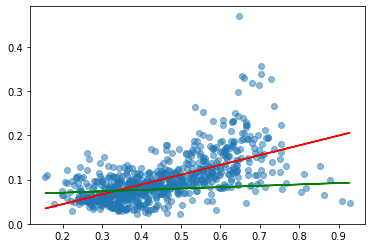

In [129]:
plt.scatter(commute,mobility,alpha=0.5)

x = np.linspace(np.min(commute),np.max(commute),num=100)
#EDIT: Plot OLS line (in red)
#EDIT: Plot WLS line (in green)
plt.plot(commute,coeff_ols[0]+coeff_ols[1]*commute,'r')
plt.plot(commute,coeff_wls[0]+coeff_wls[1]*commute,'g')

plt.show()

**Final remark:** While the OLS uncovers a linear relationship between `commute` and `mobility`, correcting for the variance of the estimated mobility using WLS shows a much weaker relationship (if any at all).